# Scatter Plots

Figures 9, 10 of arXiv:1805.02664

In [1]:
import gc
import sys
import numpy as np
import numpy.random as rand
import math
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import stats
import keras as keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
#import pickle as pickle
import tensorflow as tf
import time
import glob
import numpy.ma as ma
from keras import backend as K

import cwola_utils as cwola_utils
from cwola_utils import AddPredictionsToScatter_nestedcrossval
from cwola_utils import model_ensemble
from cwola_utils import check_eff
from cwola_utils import print_scatter_checkpoint
from cwola_utils import get_p_value

/home/Jack/.virtualenvs/Keras/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


In [3]:
data_prefix = '../data/'
numsig = 900
bin_i = 7
kfolds=5

selected_vars = np.array([7,34,11,38,13,40,16,43,19,46,33,60])-1
selected_vars_plus = np.append([0],selected_vars)
axes_list = [[0,1],[2,3],[4,5],[6,7],[8,9],[10,11],[0,2],[0,4],[0,6],[0,8],[0,10],[1,3],[1,5],[1,7],[1,9],[1,11]]

axes_labels_set = [r'$m_{J,A} \; / \; \mathrm{GeV}$',
                   r'$m_{J,B} \; / \; \mathrm{GeV}$',
                   r'$\sqrt{\tau^{(2)}_{1,A}} / \tau^{(1)}_{1,A}$',
                   r'$\sqrt{\tau^{(2)}_{1,B}} / \tau^{(1)}_{1,B}$',
                   r'$\tau^{(1)}_{21,A}$',
                   r'$\tau^{(1)}_{21,B}$',
                   r'$\tau^{(1)}_{32,A}$',
                   r'$\tau^{(1)}_{32,B}$',
                   r'$\tau^{(1)}_{43,A}$',
                   r'$\tau^{(1)}_{43,B}$',
                   r'$n_{\mathrm{trk},A}$',
                   r'$n_{\mathrm{trk},B}$']

axes_labels = [[axes_labels_set[axes[0]],axes_labels_set[axes[1]]]for axes in axes_list]
no_mass=False

mjjmin = 2001
mjjmax = 4350
mybinboundaries = np.round(np.logspace(np.log10(mjjmin), np.log10(mjjmax), num=16))
mybincenters = np.array([0.5*(mybinboundaries[i+1] + mybinboundaries[i]) for i in range(0,len(mybinboundaries)-1)])
mybinwidths = np.array([mybinboundaries[i+1] - mybinboundaries[i] for i in range(0,len(mybinboundaries)-1)])
mybincenterandwidth = np.vstack((mybincenters,mybinwidths)).T

def bin_data(data, binboundaries = mybinboundaries):
    databinned = []
    for i in range(0,len(binboundaries)-1):
        databinned.append(
            np.array([np.delete(myrow,0) for myrow in data if (myrow[0] < binboundaries[i+1] and myrow[0] >= binboundaries[i])])
        )
    return databinned

In [5]:
rand.seed(0)

bgdata = np.loadtxt(data_prefix +  'bg_dataset_0.dat')
for i in range(1,6):
    bgdata = np.append(bgdata,np.loadtxt(data_prefix + 'bg_dataset_' + str(i) + '.dat'),axis=0)

bgdata = bgdata[bgdata[:,0]>=mjjmin]

print('Number bg events after cut:', len(bgdata[bgdata[:,1]<=mjjmax]))

rand.shuffle(bgdata)

print('Adding signal data')
signaldata = np.loadtxt(data_prefix + 'W_WW_3000_400.dat')[:numsig]
signaldata = signaldata[signaldata[:,0]>=mjjmin]
print("Signal data:",len(signaldata))
bg_plus_signal = np.nan_to_num(np.append(signaldata,bgdata,axis=0))
rand.shuffle(bg_plus_signal)


def make_tauratio(data):
    data = np.copy(data)
    data[:,[18,45]] = np.nan_to_num(data[:,[18,45]]/data[:,[15,42]])
    data[:,[15,42]] = np.nan_to_num(data[:,[15,42]]/data[:,[12,39]])
    data[:,[12,39]] = np.nan_to_num(data[:,[12,39]]/data[:,[9,36]])
    data[:,[10,37]] = np.nan_to_num(np.sqrt(data[:,[10,37]])/data[:,[9,36]])
    data = data[(data[:,6] < 500) & (data[:,33] < 300)]
    return data

bg_plus_signal = make_tauratio(bg_plus_signal)

def myprepreprocessor(predata, massvars=None):
    if massvars is None:
        massvars = [0,1]
    newdata = np.copy(predata)
    newdata[:,massvars] = np.nan_to_num(np.log10(newdata[:,massvars]+40))
    return newdata

bg_plus_signal=bg_plus_signal[:,selected_vars_plus]
myscaler = preprocessing.StandardScaler().fit(myprepreprocessor(bg_plus_signal,massvars=[1,2])[:,1:])
def preprocess(data):
    return np.clip(myscaler.transform(myprepreprocessor(data,massvars=[0,1])),-3,3)
#bg_plus_signal[:,1:] = preprocess(bg_plus_signal[:,1:])

rand.shuffle(bg_plus_signal)

bg_plus_signal_binned = bin_data(bg_plus_signal)
del bg_plus_signal


Number bg events after cut: 553388
Adding signal data
Signal data: 877


/home/Jack/.virtualenvs/Keras/lib/python3.4/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/home/Jack/.virtualenvs/Keras/lib/python3.4/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/home/Jack/.virtualenvs/Keras/lib/python3.4/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/home/Jack/.virtualenvs/Keras/lib/python3.4/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


In [6]:
rand.seed(0)
bgdata = np.loadtxt(data_prefix + 'bg_dataset_0.dat')
for i in range(1,6):
    bgdata = np.append(bgdata,np.loadtxt(data_prefix + 'bg_dataset_' + str(i) + '.dat'),axis=0)

bgdata = bgdata[bgdata[:,0]>=mjjmin]

rand.shuffle(bgdata)

bg_plus_signal_nosig = np.nan_to_num(bgdata)

bg_plus_signal_nosig = make_tauratio(bg_plus_signal_nosig)

def myprepreprocessor_nosig(predata, massvars=None):
    if massvars is None:
        massvars = [0,1]
    newdata = np.copy(predata)
    newdata[:,massvars] = np.nan_to_num(np.log10(newdata[:,massvars]+40))
    return newdata

bg_plus_signal_nosig = bg_plus_signal_nosig[:,selected_vars_plus]
myscaler_nosig = preprocessing.StandardScaler().fit(myprepreprocessor_nosig(bg_plus_signal_nosig,massvars=[1,2])[:,1:])
def preprocess_nosig(data):
    return np.clip(myscaler_nosig.transform(myprepreprocessor_nosig(data,massvars=[0,1])),-3,3)
#bg_plus_signal[:,1:] = preprocess(bg_plus_signal[:,1:])

rand.shuffle(bg_plus_signal_nosig)

bg_plus_signal_binned_nosig = bin_data(bg_plus_signal_nosig)
del bg_plus_signal_nosig


/home/Jack/.virtualenvs/Keras/lib/python3.4/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/home/Jack/.virtualenvs/Keras/lib/python3.4/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/home/Jack/.virtualenvs/Keras/lib/python3.4/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/home/Jack/.virtualenvs/Keras/lib/python3.4/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


In [7]:
# import warnings
# warnings.filterwarnings('ignore')

# ntries = myargs['-it']
# times = list()
# bin_i = myargs['-bin']
# print("Working on bin ", bin_i)


# numvars=len(selected_vars)
# if no_mass:
#     numvars = numvars-2

# #batch_size = round(len(data_train)/20)
# batch_size =5000
# model_utils = {}



In [8]:
signaldata = make_tauratio(signaldata)
bgdata = make_tauratio(bgdata)
binned_signaldata = bin_data(signaldata[:,selected_vars_plus])
binned_bgdata = bin_data(bgdata[:,selected_vars_plus])

/home/Jack/.virtualenvs/Keras/lib/python3.4/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/home/Jack/.virtualenvs/Keras/lib/python3.4/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/home/Jack/.virtualenvs/Keras/lib/python3.4/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/home/Jack/.virtualenvs/Keras/lib/python3.4/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


In [9]:
signalregion_signaldata = np.concatenate((binned_signaldata[bin_i-1],
                                          binned_signaldata[bin_i],
                                          binned_signaldata[bin_i+1]),
                                         axis=0)
signalregion_bgdata = np.concatenate((binned_bgdata[bin_i-1],
                                          binned_bgdata[bin_i],
                                          binned_bgdata[bin_i+1]),
                                         axis=0)

sidebandregion_signaldata = np.concatenate((binned_signaldata[bin_i-3],
                                            binned_signaldata[bin_i-2],
                                            binned_signaldata[bin_i+2],
                                            binned_signaldata[bin_i+3]),
                                            axis=0)
sidebandregion_bgdata = np.concatenate((binned_bgdata[bin_i-3],
                                        binned_bgdata[bin_i-2],
                                        binned_bgdata[bin_i+2],
                                        binned_bgdata[bin_i+2]),
                                        axis=0)

In [10]:
model_names = []
merged_model_utils_sig = model_ensemble(bg_plus_signal_binned, bin_i = bin_i, kfolds=kfolds, preprocess = preprocess)
for i in range(5):
    model_names.append(data_prefix + "finalscan_signal/sig_bin7_7_ensemble_k" + str(i) + ".h5")
merged_model_utils_sig.load_all_ensemble_models(model_names = model_names)    

model_names = []
merged_model_utils_nosig = model_ensemble(bg_plus_signal_binned_nosig, bin_i = bin_i, kfolds=kfolds, preprocess = preprocess)
for i in range(5):
    model_names.append(data_prefix + "finalscan_nosignal/0_005_7_ensemble_k" + str(i) + ".h5")
merged_model_utils_nosig.load_all_ensemble_models(model_names = model_names)    


data_sig = []
predictions_sig = []
for k in range(merged_model_utils_sig.kfolds):
    data_sig.append(merged_model_utils_sig.get_kth_signalregion_data(k))
    predictions_sig.append(merged_model_utils_sig.avg_model_predict_onek(data_sig[-1], k))

data_sig_sideband = []
predictions_sig_sideband = []
for k in range(merged_model_utils_sig.kfolds):
    data_sig_sideband.append(merged_model_utils_sig.get_kth_sidebandregion_data(k))
    predictions_sig_sideband.append(merged_model_utils_sig.avg_model_predict_onek(data_sig_sideband[-1], k))
    
data_nosig = []
predictions_nosig = []
for k in range(merged_model_utils_nosig.kfolds):
    data_nosig.append(merged_model_utils_nosig.get_kth_signalregion_data(k))
    predictions_nosig.append(merged_model_utils_nosig.avg_model_predict_onek(data_nosig[-1], k))

/home/Jack/.virtualenvs/Keras/lib/python3.4/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [25]:
def AddPredictionsToScatter_fourcol(data_set,
                                    predictions_set,
                                    data_set_nosig,
                                    predictions_set_nosig,
                                    true_bg,
                                    true_sig,
                                    axes_list=[[0,1]],
                                    rates = np.array([0.5,0.95,0.98,0.99]),
                                    sizes = np.array([0.1,0.1,0.1,0.1,1.0]),
                                    colors=['silver','grey','khaki','goldenrod','firebrick'],
                                    axes_labels=None,
                                    logx = False,
                                    fontsize=30,
                                    spacing=0.1,
                                    sharex='col',
                                    sharey='row',
                                    plot_labels = None,
                                    thresh=None,
                                   thresh_nosig=None):
    
    plt.rc('xtick',labelsize=fontsize)
    plt.rc('ytick',labelsize=fontsize)

    if axes_labels == None:
        axes_labels = [[None,None] for axes in axes_list]
    points_list_init = False
    for data_i, predictions in enumerate(predictions_set):
        extended_rates = np.insert(rates,0,0.0)
        extended_rates = np.append(extended_rates,1.0)
        sorted_args = np.argsort(predictions)
        total_num = len(sorted_args)

        if thresh is None:
            points_list_temp = [data_set[data_i][sorted_args[int(extended_rates[i] * total_num):int(extended_rates[i+1] * total_num)]] for i in range(0,len(extended_rates)-1)]
        else:
            points_list_temp = [data_set[data_i][predictions < thresh[data_i]],data_set[data_i][predictions > thresh[data_i]]]
#        points_list_temp = [data_set[data_i][sorted_args[int(extended_rates[i] * total_num):int(extended_rates[i+1] * total_num)]] for i in range(0,len(extended_rates)-1)]
        
        if points_list_init:
            points_list = [np.append(points_list[i], points_list_temp[i],axis=0) for i in range(len(points_list_temp))]
        else:
            points_list = points_list_temp
            points_list_init = True
    
    ncol=4
    nrow=len(axes_list)


    f, axarr = plt.subplots(nrow,ncol,
                            sharex=sharex, sharey=sharey,
                            figsize=(6*ncol,5*nrow))

    #plt.figure(figsize=(6*ncol,nrow*5))


    for h, axes in enumerate(axes_list):
        #plt.subplot(nrow, ncol, (h)*ncol+1)
        axarr[h,0].grid()
        if logx:
            axarr[h,0].set_xscale("log")
            axarr[h,0].set_xlim([3,500])
            axarr[h,1].set_xscale("log")
            axarr[h,1].set_xlim([3,500])
            axarr[h,2].set_xscale("log")
            axarr[h,2].set_xlim([3,500])
            axarr[h,3].set_xscale("log")
            axarr[h,3].set_xlim([3,500])
#         plt.xlabel(axes_labels[h][0])
#         plt.ylabel(axes_labels[h][1])
        axarr[h,0].scatter(true_bg[:,axes[0]],true_bg[:,axes[1]],
                    s=sizes[0], color=colors[0],rasterized=True)
        axarr[h,0].scatter(true_sig[:,axes[0]],true_sig[:,axes[1]],
                    s=sizes[0], color=colors[0],rasterized=True)
            
    for h, axes in enumerate(axes_list):
        #plt.subplot(nrow, ncol, (h)*ncol+2)
        axarr[h,1].grid()
#         plt.xlabel(axes_labels[h][0])
#         plt.ylabel(axes_labels[h][1])
        axarr[h,1].scatter(true_bg[:,axes[0]],true_bg[:,axes[1]],
                    s=sizes[0], color=colors[0],rasterized=True)
        axarr[h,1].scatter(true_sig[:,axes[0]],true_sig[:,axes[1]],
                    s=sizes[-1], color=colors[-1],rasterized=True)
        
    for h, axes in enumerate(axes_list):
        #plt.subplot(nrow, ncol, (h)*ncol+3)
        axarr[h,2].grid()
        for i, points in enumerate(points_list):
            size = sizes[i]
#            axarr[h,2].set_xlabel(axes_labels[h][0])
#             plt.ylabel(axes_labels[h][1])
            axarr[h,2].scatter(points[:,axes[0]],points[:,axes[1]],
                        s=size, color=colors[i],rasterized=True)
        
    points_list_init = False
    for data_i, predictions in enumerate(predictions_set_nosig):
        extended_rates = np.insert(rates,0,0.0)
        extended_rates = np.append(extended_rates,1.0)
        sorted_args = np.argsort(predictions)
        total_num = len(sorted_args)

        
        if thresh_nosig is None:
            points_list_temp = [data_set_nosig[data_i][sorted_args[int(extended_rates[i] * total_num):int(extended_rates[i+1] * total_num)]] for i in range(0,len(extended_rates)-1)]
        else:
            points_list_temp = [data_set_nosig[data_i][predictions < thresh_nosig[data_i]],data_set_nosig[data_i][predictions > thresh_nosig[data_i]]]
      
#       points_list_temp = [data_set_nosig[data_i][sorted_args[int(extended_rates[i] * total_num):int(extended_rates[i+1] * total_num)]] for i in range(0,len(extended_rates)-1)]

        if points_list_init:
            points_list = [np.append(points_list[i], points_list_temp[i],axis=0) for i in range(len(points_list_temp))]
        else:
            points_list = points_list_temp
            points_list_init = True
            
    for h, axes in enumerate(axes_list):
        #axarr[h,0].subplot(nrow, ncol, (h)*ncol+4)
        axarr[h,3].grid()
        for i, points in enumerate(points_list):
            size = sizes[i]
#             plt.xlabel(axes_labels[h][0])
#             plt.ylabel(axes_labels[h][1])
            axarr[h,3].scatter(points[:,axes[0]],points[:,axes[1]],
                        s=size, color=colors[i],rasterized=True)

    for axrow in axarr:
        for ax in axrow:
            ax.label_outer()

    #f.subplots_adjust(vspace=0)
    titles=[r'All data',
           r'Truth signal',
           r'NN selection with signal',
           r'NN selection, bg only']


    f.subplots_adjust(hspace=spacing)
    f.subplots_adjust(wspace=spacing)
    
    for i, row in enumerate(axarr):
        for j, cell in enumerate(row):
            if plot_labels == None:
                if i < 3:
                    cell.text(0.95,0.9,'Heavy jet',transform=cell.transAxes,fontsize=fontsize,
                              horizontalalignment='right',
                              bbox=dict(facecolor='white',edgecolor='none', alpha=1.0))
                if i >= 3:
                    cell.text(0.95,0.9,'Light jet',transform=cell.transAxes,fontsize=fontsize,
                              horizontalalignment='right',
                              bbox=dict(facecolor='white',edgecolor='none', alpha=1.0))
            else:
                cell.text(0.95,0.9,plot_labels[i],transform=cell.transAxes,fontsize=fontsize,
                              horizontalalignment='right',
                              bbox=dict(facecolor='white',edgecolor='none', alpha=1.0))
            if i == 0:
                cell.set_title(titles[j],fontsize=fontsize)
            if i == len(axarr) - 1:
                cell.set_xlabel(r'$m_J / \mathrm{GeV}$',fontsize=fontsize)
            if j == 0:
                cell.set_ylabel(axes_labels[i][1],fontsize=fontsize)
                
    #plt.tight_layout()
    return f, axarr


### Figure 10

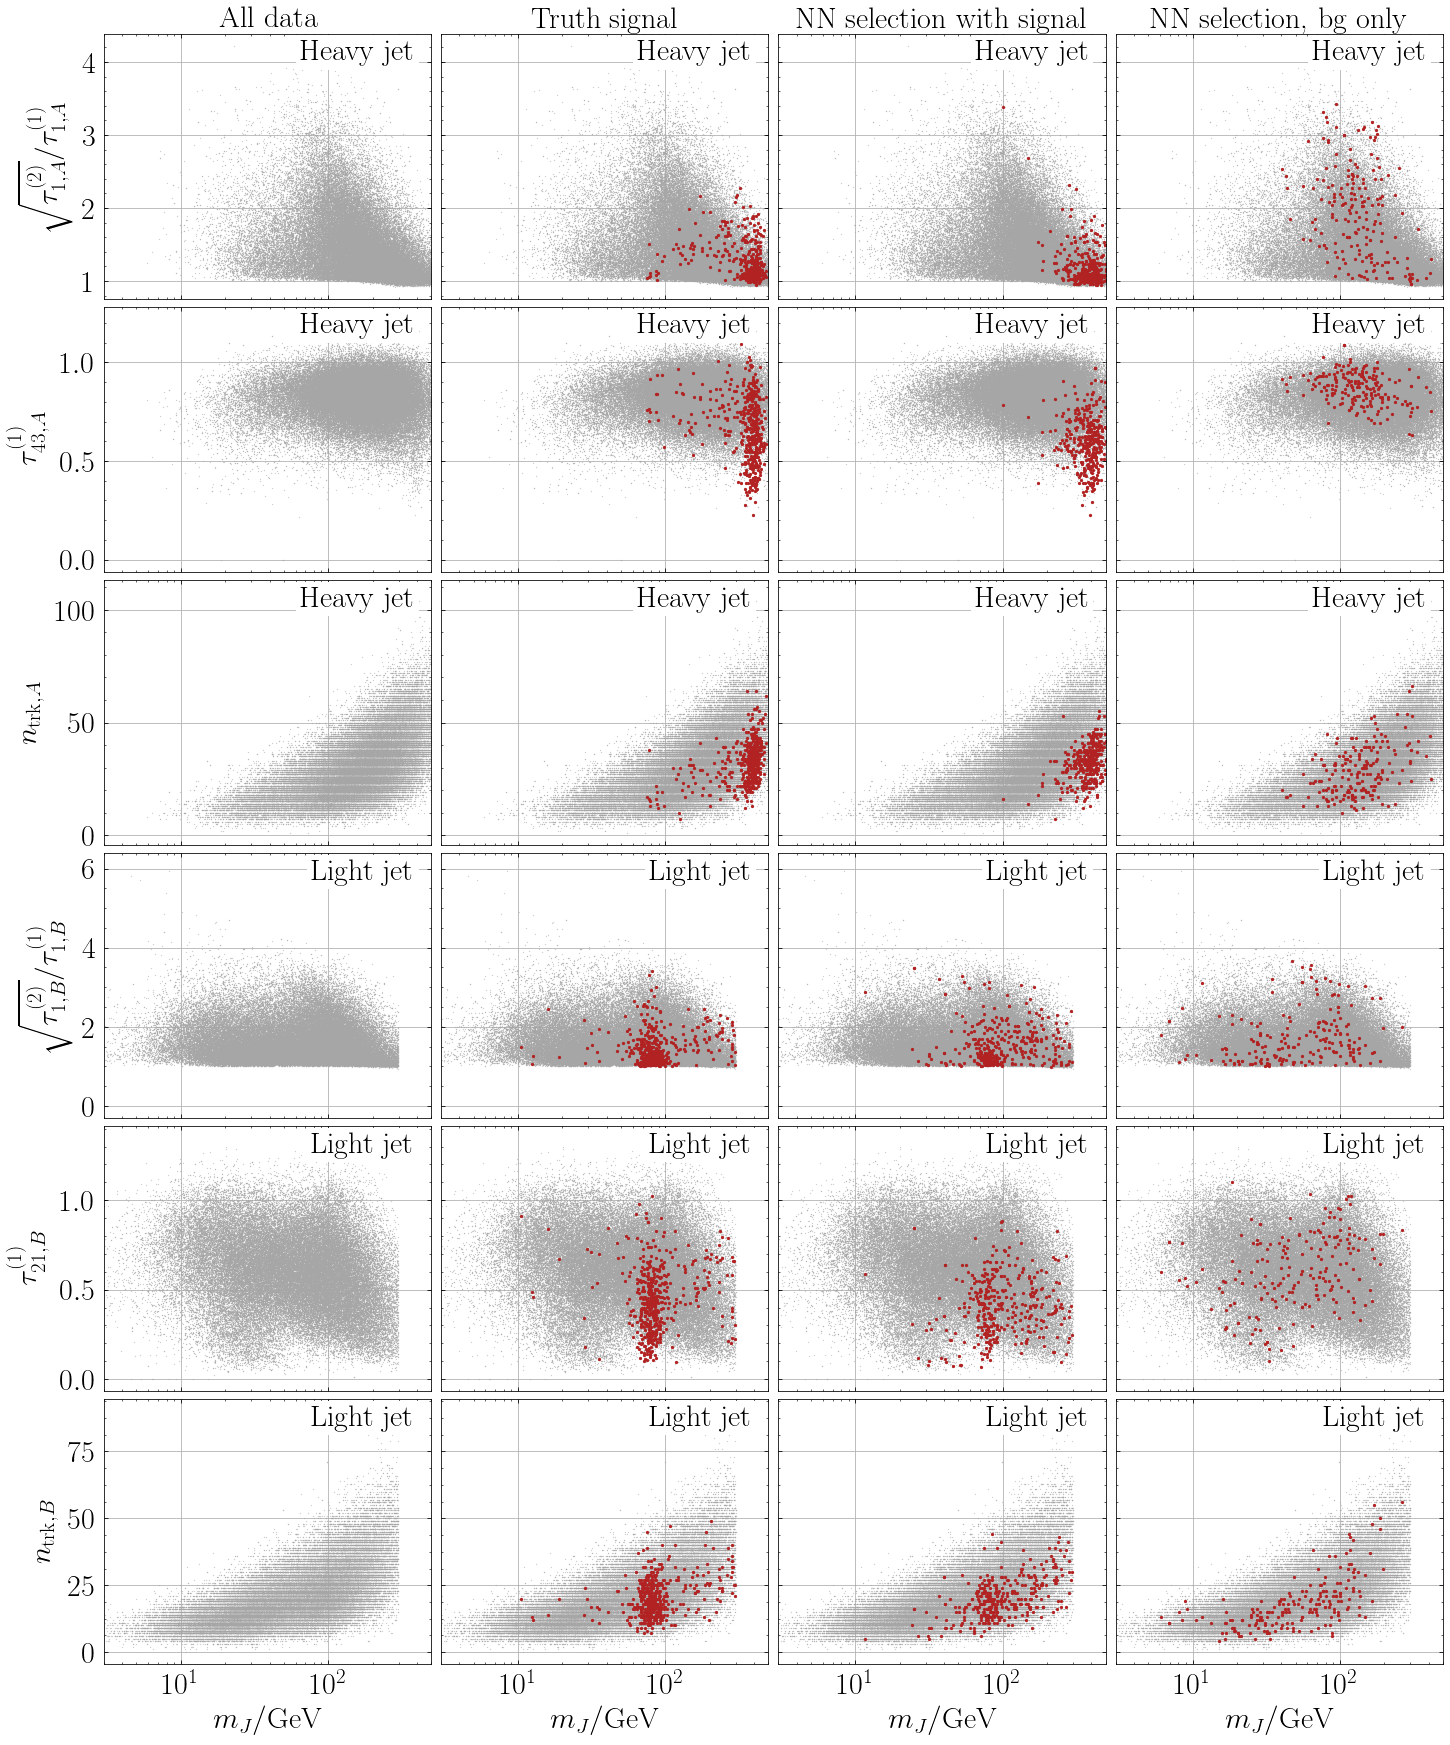

In [28]:
del axes_list
# axes_list=axes_list
# axes_labels=axes_labels
rates = np.array([0.998])
sizes = np.array([0.05,5])
colors = ['0.65','firebrick']

plt.rc('axes', axisbelow=True)

axes_list = [[0,2],[0,8],[0,10],[1,3],[1,5],[1,11]]
axes_labels = [[axes_labels_set[axes[0]],axes_labels_set[axes[1]]] for axes in axes_list]

f, axarr = AddPredictionsToScatter_fourcol(data_sig,
                                           predictions_sig,
                                           data_nosig,
                                           predictions_nosig,
                                           signalregion_bgdata,
                                           signalregion_signaldata,
                                           axes_list=[[0,2],[0,8],[0,10],[1,3],[1,5],[1,11]],
                                           axes_labels=axes_labels,
                                           rates=rates,
                                           colors=colors,
                                           sizes=sizes,
                                           logx=True,
                                           fontsize=30,
                                           spacing=0.03,
                                          thresh=merged_model_utils_sig.get_thresh_all(eff = 0.002),
                                          thresh_nosig=merged_model_utils_nosig.get_thresh_all(eff = 0.002))

# axarr[0,0].set_yticks([0,0.2,0.4,0.6,0.8])
# axarr[3,0].set_yticks([0,0.2,0.4,0.6,0.8])

plt.savefig('/mnt/c/Users/Jack/Physics/jj_for_NN/12D_test/scatterarray.pdf',bbox_inches='tight')
plt.show()

### Reduced version of Figure 10

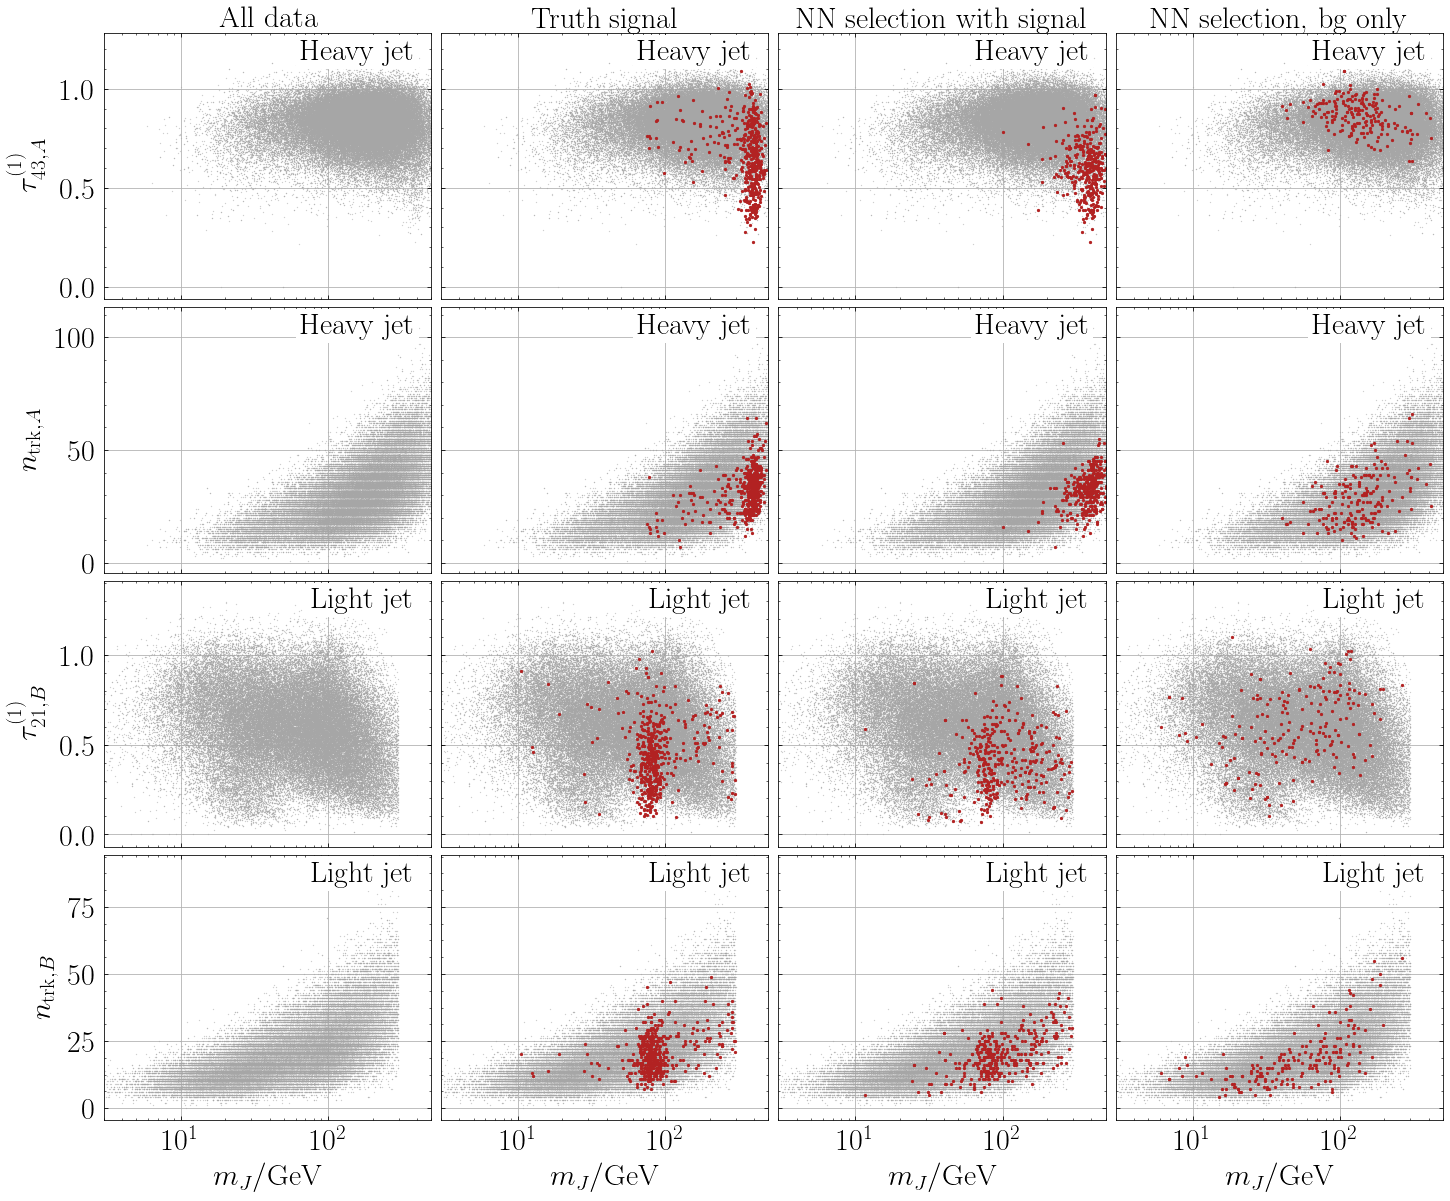

In [27]:
del axes_list
# axes_list=axes_list
# axes_labels=axes_labels
rates = np.array([0.998])
sizes = np.array([0.05,5])
colors = ['0.65','firebrick']

plt.rc('axes', axisbelow=True)

axes_list = [[0,8],[0,10],[1,5],[1,11]]
axes_labels = [[axes_labels_set[axes[0]],axes_labels_set[axes[1]]] for axes in axes_list]

f, axarr = AddPredictionsToScatter_fourcol(data_sig,
                                           predictions_sig,
                                           data_nosig,
                                           predictions_nosig,
                                           signalregion_bgdata,
                                           signalregion_signaldata,
                                           axes_list=axes_list,
                                           axes_labels=axes_labels,
                                           rates=rates,
                                           colors=colors,
                                           sizes=sizes,
                                           logx=True,
                                           fontsize=30,
                                           spacing=0.03,
                                           plot_labels=['Heavy jet','Heavy jet','Light jet','Light jet'],
                                          thresh=merged_model_utils_sig.get_thresh_all(eff = 0.002),
                                          thresh_nosig=merged_model_utils_nosig.get_thresh_all(eff = 0.002))

# axarr[0,0].set_yticks([0,0.2,0.4,0.6,0.8])
# axarr[3,0].set_yticks([0,0.2,0.4,0.6,0.8])

plt.savefig('/mnt/c/Users/Jack/Physics/jj_for_NN/scatterarray_small.pdf',bbox_inches='tight')
plt.show()

In [20]:
def AddPredictionsToScatter_fourcol_mJ(data_set, predictions_set,true_bg, true_sig,true_bg_sideband, true_sig_sideband, axes_list=[[0,1]],
                                    rates = np.array([0.5,0.95,0.98,0.99]),
                                    sizes = np.array([0.1,0.1,0.1,0.1,1.0]),
                                    colors=['silver','grey','khaki','goldenrod','firebrick'],
                                    axes_labels=None,
                                    logx = False,logy = False,
                                    fontsize=30,
                                    spacing=0.1,
                                    alpha_bg = 0.1,
                                    NNtitle=r'NN selection, 0.2\%',
                                    thresh = None):
    
    plt.rc('xtick',labelsize=fontsize)
    plt.rc('ytick',labelsize=fontsize)

#     if usethresh:
#         thresh = rates
    
    if axes_labels == None:
        axes_labels = [[None,None] for axes in axes_list]
    points_list_init = False
    for data_i, predictions in enumerate(predictions_set):
        extended_rates = np.insert(rates,0,0.0)
        extended_rates = np.append(extended_rates,1.0)
        sorted_args = np.argsort(predictions)
        total_num = len(sorted_args)

        
        if thresh is None:
            points_list_temp = [data_set[data_i][sorted_args[int(extended_rates[i] * total_num):int(extended_rates[i+1] * total_num)]] for i in range(0,len(extended_rates)-1)]
        else:
            points_list_temp = [data_set[data_i][predictions < thresh[data_i]],data_set[data_i][predictions > thresh[data_i]]]
            
        if points_list_init:
            points_list = [np.append(points_list[i], points_list_temp[i],axis=0) for i in range(len(points_list_temp))]
        else:
            points_list = points_list_temp
            points_list_init = True
    
    ncol=4
    nrow=len(axes_list)
        
    f, axarr = plt.subplots(nrow,ncol,
                            sharex='col', sharey='row',
                            figsize=(6*ncol,5*nrow))

    #plt.figure(figsize=(6*ncol,nrow*5))


    for h, axes in enumerate(axes_list):
        #plt.subplot(nrow, ncol, (h)*ncol+1)
        axarr[0].grid()
        if logx:
            axarr[0].set_xscale("log")
            axarr[0].set_xlim([3,500])
            axarr[1].set_xscale("log")
            axarr[1].set_xlim([3,500])
            axarr[2].set_xscale("log")
            axarr[2].set_xlim([3,500])
            axarr[3].set_xscale("log")
            axarr[3].set_xlim([3,500])
        if logy:
            axarr[0].set_yscale("log")
            axarr[0].set_ylim([3,300])
            axarr[1].set_yscale("log")
            axarr[1].set_ylim([3,300])
            axarr[2].set_yscale("log")
            axarr[2].set_ylim([3,300])
            axarr[3].set_yscale("log")
            axarr[3].set_ylim([3,300])
#         plt.xlabel(axes_labels[h][0])
#         plt.ylabel(axes_labels[h][1])
        axarr[0].scatter(true_bg[:,axes[0]],true_bg[:,axes[1]],
                    s=sizes[0], color=colors[0], alpha=alpha_bg,rasterized=True)
        axarr[0].scatter(true_sig[:,axes[0]],true_sig[:,axes[1]],
                    s=sizes[0], color=colors[0],alpha=alpha_bg,rasterized=True)
        
    for h, axes in enumerate(axes_list):
        #plt.subplot(nrow, ncol, (h)*ncol+1)
        axarr[1].grid()
        axarr[1].scatter(true_bg_sideband[:,axes[0]],true_bg_sideband[:,axes[1]],
                    s=sizes[0], color=colors[0], alpha=alpha_bg*len(true_bg)/len(true_bg_sideband),rasterized=True)
        axarr[1].scatter(true_sig_sideband[:,axes[0]],true_sig_sideband[:,axes[1]],
                    s=sizes[0], color=colors[0],alpha=alpha_bg*len(true_bg)/len(true_bg_sideband),rasterized=True)
            
    for h, axes in enumerate(axes_list):
        #plt.subplot(nrow, ncol, (h)*ncol+2)
        axarr[3].grid()
#         plt.xlabel(axes_labels[h][0])
#         plt.ylabel(axes_labels[h][1])
        axarr[3].scatter(true_bg[:,axes[0]],true_bg[:,axes[1]],
                    s=sizes[0], color=colors[0],alpha=alpha_bg,rasterized=True)
        axarr[3].scatter(true_sig[:,axes[0]],true_sig[:,axes[1]],
                    s=sizes[-1], color=colors[-1],rasterized=True)
    
    for h, axes in enumerate(axes_list):
        #plt.subplot(nrow, ncol, (h)*ncol+3)
        axarr[2].grid()
        for i, points in enumerate(points_list):
            alpha = 1.0
            if i == 0:
                alpha = alpha_bg
            size = sizes[i]
#            axarr[h,2].set_xlabel(axes_labels[h][0])
#             plt.ylabel(axes_labels[h][1])
            axarr[2].scatter(points[:,axes[0]],points[:,axes[1]],
                        s=size, color=colors[i],alpha=alpha,rasterized=True)
        

    for ax in axarr:
        ax.label_outer()
    #f.subplots_adjust(vspace=0)
    titles=[r'Signal Region',
           r'Sideband',
           NNtitle,
           r'Truth signal']


    f.subplots_adjust(hspace=spacing)
    f.subplots_adjust(wspace=spacing)
    
    for j, cell in enumerate(axarr):
#        for j, cell in enumerate(row):
        i = 0
        if i == 0:
            cell.set_title(titles[j],fontsize=fontsize)
        if i == 0:
            cell.set_xlabel(r'$m_{J,A} \; / \; \mathrm{GeV}$',fontsize=fontsize)
        if j == 0:
            cell.set_ylabel(axes_labels[i][1],fontsize=fontsize)
                
    #plt.tight_layout()
    return f, axarr


### Figure 9

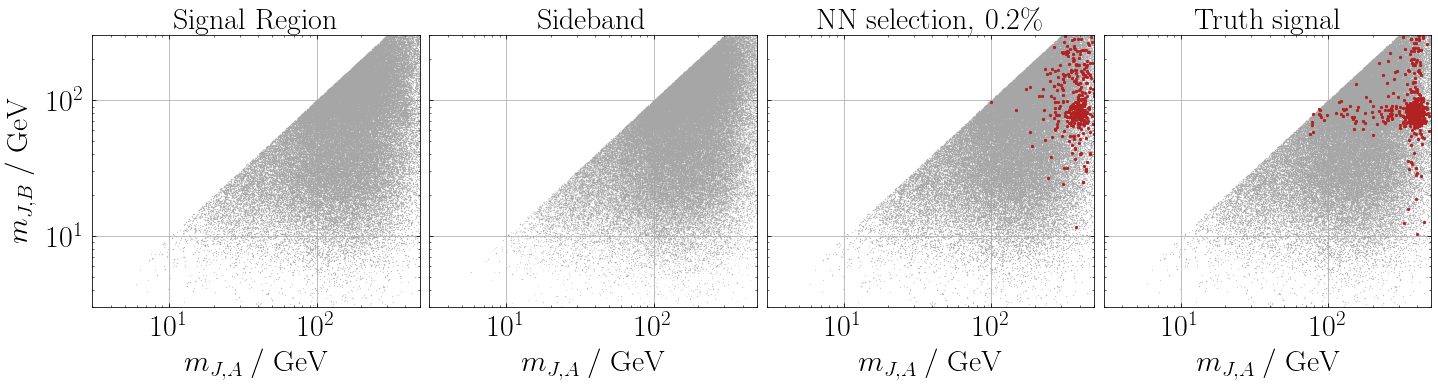

In [21]:
axes_list=axes_list
axes_labels=axes_labels
rates = np.array([0.998])
sizes = np.array([0.05,5])
colors = ['0.65','firebrick']

plt.rc('axes', axisbelow=True)

axes_list = [[0,1]]
axes_labels = [[axes_labels_set[axes[0]],axes_labels_set[axes[1]]] for axes in axes_list]

f, axarr = AddPredictionsToScatter_fourcol_mJ(data_sig, predictions_sig, signalregion_bgdata,signalregion_signaldata,
                                              sidebandregion_bgdata,sidebandregion_signaldata,
                                              axes_list=axes_list,axes_labels=axes_labels,
                                              thresh=merged_model_utils_sig.get_thresh_all(eff = 0.002),
                                              colors=colors,sizes=sizes,
                                              logx=True,logy=True,
                                              fontsize=30,
                                              spacing=0.03,
                                              alpha_bg = 1.0)

# axarr[0,0].set_yticks([0,0.2,0.4,0.6,0.8])
# axarr[3,0].set_yticks([0,0.2,0.4,0.6,0.8])

plt.savefig('/mnt/c/Users/Jack/Physics/jj_for_NN/12D_test/scattermJJ.pdf',bbox_inches='tight')
plt.show()